# Tow_matters PiCar

In [1]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from natsort import natsorted

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten,Dropout, BatchNormalization, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers
from tensorflow_addons.metrics import RSquare

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load csv file 
df = pd.read_csv('../datasets/PiCar/training_norm.csv', index_col=False)
df.head()

,image_id,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


In [3]:
df.shape

(13793, 3)

In [4]:
#df = df.drop('image_id', axis=1)
#df.head()

In [5]:
df['angle'].value_counts()

0.7500    2123
0.5000    2046
0.6875    2007
0.6250    1963
0.5625    1609
0.4375    1467
0.8125    1147
0.3750     428
0.8750     301
0.3125     213
0.2500     104
0.1250      99
0.1875      98
0.9375      65
0.0000      60
1.0000      35
0.0625      28
Name: angle, dtype: int64

In [6]:
a = df['image_id'].tolist()
b = [x for x in range(a[0], a[-1] + 1)]
missing_vals = list(set(a) ^ set(b))
print('Missing data:', missing_vals)

Missing data: [3141, 3999, 4895, 8285, 10171]


In [7]:
images_dir = '../datasets/PiCar/train/training_data'
file_list = os.listdir(images_dir)
image_paths = []
pattern = "*.png"

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(images_dir,filename))

image_paths = natsorted(image_paths)
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/3141.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/3999.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/4895.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/8285.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/10171.png']



images = pd.DataFrame (image_paths, columns = ['images'])
images.describe()

,images
count,13793
unique,13793
top,../datasets/PiCar/train/training_data/10297.png
freq,1


In [8]:
df_all = pd.concat([df, images], axis=1)
df_all = df_all.drop('image_id', axis=1)
df_all.tail()

,angle,speed,images
13788,0.6250,1.0,../datasets/PiCar/train/training_data/13794.png
13789,0.4375,1.0,../datasets/PiCar/train/training_data/13795.png
13790,0.5625,0.0,../datasets/PiCar/train/training_data/13796.png
13791,0.6250,0.0,../datasets/PiCar/train/training_data/13797.png
13792,0.6875,1.0,../datasets/PiCar/train/training_data/13798.png


In [9]:
df_all.shape

(13793, 3)

In [10]:
#le = LabelEncoder()
#df_all['angle']= le.fit_transform(df_all['angle'])
#df_all.head()

image_path: ../datasets/PiCar/train/training_data/11.png
steering_Angle: 0.6875
Speed: 0.0


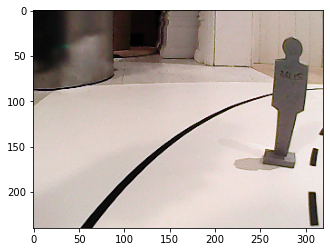

In [11]:
image_paths = df_all['images'].tolist()
steering_angles = df_all['angle'].tolist()
speed = df_all['speed'].tolist()


image_index = 10
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index]) 
print("steering_Angle:", steering_angles[image_index]) 
print("Speed:", speed[image_index]) 


In [12]:
X_train, X_valid = train_test_split( df_all, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))



Training data: 11034
Validation data: 2759


In [13]:
class Nvidia_CNN(tf.keras.Model):
  def __init__(self):
    super().__init__()
    
    self.conv1 = Conv2D(24, 5,strides=(2, 2), activation='relu')
    self.conv2 = Conv2D(36, 5, strides=(2, 2),activation='relu')
    self.conv3 = Conv2D(48, 5, strides=(2, 2),activation='relu')
    self.conv4 = Conv2D(64, 3, strides=(2, 2), activation='relu')
    self.drop1 = Dropout(0.25)
    self.conv5 = Conv2D(64, 3, strides=(2, 2),activation='relu')
    
    self.flatten = Flatten()
    self.drop2 = Dropout(0.25)
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(64, activation='relu')
    self.d3 = Dense(32, activation='relu')
    #self.d4 = Dense(16, activation='relu')
    
    self.Y1 = Dense(1, activation='relu')    
    self.Y2 = Dense(1, activation = 'sigmoid')

  def call(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.drop1(x)
    x = self.conv5(x)
    
    x = self.flatten(x)
    x = self.drop2(x)
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    #x = self.d4(x)
    
    
    y1 = self.Y1(x)
    y2 = self.Y2(x)
    
    return y1,y2

In [38]:
tf.keras.backend.clear_session()

# Early stop added
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

train_gen = ImageDataGenerator(rescale=1./255,width_shift_range=0.1, height_shift_range=0.1)
val_gen = ImageDataGenerator(rescale=1./255)

model = Nvidia_CNN()


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                       loss={
        "output_1" : tf.keras.losses.MeanSquaredError(),
        "output_2" : tf.keras.losses.BinaryCrossentropy(from_logits=False)},
        metrics={"output_1": [RSquare()], "output_2": 'accuracy'})


history= model.fit(train_gen.flow_from_dataframe(X_train,x_col='images',y_col=['angle','speed'],class_mode='multi_output',
                                        target_size=(240,180),batch_size=32),
    validation_data=val_gen.flow_from_dataframe(X_valid, x_col='images',y_col=['angle','speed'],class_mode='multi_output',
    target_size=(240,180),batch_size=32), callbacks= [callback], epochs=30)

model.save('model/Nvidia_CNN',save_format='tf')

Found 11034 validated image filenames.
Found 2759 validated image filenames.
Epoch 1/30
345/345 [==============================] - 101s 289ms/step - loss: 0.5986 - output_1_loss: 0.0412 - output_2_loss: 0.5574 - output_1_r_square: -0.7208 - output_2_accuracy: 0.7365 - val_loss: 0.5619 - val_output_1_loss: 0.0275 - val_output_2_loss: 0.5344 - val_output_1_r_square: -0.0953 - val_output_2_accuracy: 0.7412
Epoch 2/30
345/345 [==============================] - 98s 285ms/step - loss: 0.3729 - output_1_loss: 0.0295 - output_2_loss: 0.3434 - output_1_r_square: -0.2313 - output_2_accuracy: 0.8577 - val_loss: 0.2412 - val_output_1_loss: 0.0232 - val_output_2_loss: 0.2180 - val_output_1_r_square: 0.0759 - val_output_2_accuracy: 0.9155
Epoch 3/30
345/345 [==============================] - 99s 286ms/step - loss: 0.2336 - output_1_loss: 0.0241 - output_2_loss: 0.2096 - output_1_r_square: -0.0042 - output_2_accuracy: 0.9254 - val_loss: 0.2535 - val_output_1_loss: 0.0194 - val_output_2_loss: 0.2341 -

Epoch 26/30
345/345 [==============================] - 98s 285ms/step - loss: 0.0882 - output_1_loss: 0.0108 - output_2_loss: 0.0774 - output_1_r_square: 0.5476 - output_2_accuracy: 0.9711 - val_loss: 0.0912 - val_output_1_loss: 0.0096 - val_output_2_loss: 0.0816 - val_output_1_r_square: 0.6172 - val_output_2_accuracy: 0.9681
Epoch 27/30
345/345 [==============================] - 98s 283ms/step - loss: 0.0867 - output_1_loss: 0.0105 - output_2_loss: 0.0762 - output_1_r_square: 0.5637 - output_2_accuracy: 0.9702 - val_loss: 0.0920 - val_output_1_loss: 0.0135 - val_output_2_loss: 0.0784 - val_output_1_r_square: 0.4609 - val_output_2_accuracy: 0.9638
Epoch 28/30
345/345 [==============================] - 99s 286ms/step - loss: 0.0872 - output_1_loss: 0.0106 - output_2_loss: 0.0766 - output_1_r_square: 0.5574 - output_2_accuracy: 0.9707 - val_loss: 0.0855 - val_output_1_loss: 0.0093 - val_output_2_loss: 0.0762 - val_output_1_r_square: 0.6305 - val_output_2_accuracy: 0.9685
Epoch 29/30
345/

INFO:tensorflow:Assets written to: model/Nvidia_CNN/assets


INFO:tensorflow:Assets written to: model/Nvidia_CNN/assets


In [39]:
def plots(history):
    # summarize history for accuracy
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(10,6))
    
    ax1.set_title('Angle R Squared')
    ax1.plot(history.history['output_1_r_square'])
    ax1.plot(history.history['val_output_1_r_square'])
    ax1.set_yscale('log')
    ax1.legend(['train', 'test'], loc='lower right')
    
    ax2.set_title('Speed Accuracy')
    ax2.plot(history.history['output_2_accuracy'])
    ax2.plot(history.history['val_output_2_accuracy'])
    ax2.set_yscale('log')
    ax2.legend(['train', 'test'], loc='lower right')
    
    # summarize history for loss
    ax3.set_title('Angle MSE loss')  
    ax3.plot(history.history['output_1_loss'])
    ax3.plot(history.history['val_output_1_loss'])
    ax3.set_yscale('log')
    ax3.legend(['train', 'test'], loc='upper right')
   
    ax4.set_title('Speed loss')
    ax4.plot(history.history['output_2_loss'])
    ax4.plot(history.history['val_output_2_loss'])
    ax4.set_yscale('log')
    ax4.legend(['train', 'test'], loc='upper right')
    plt.show()
    
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

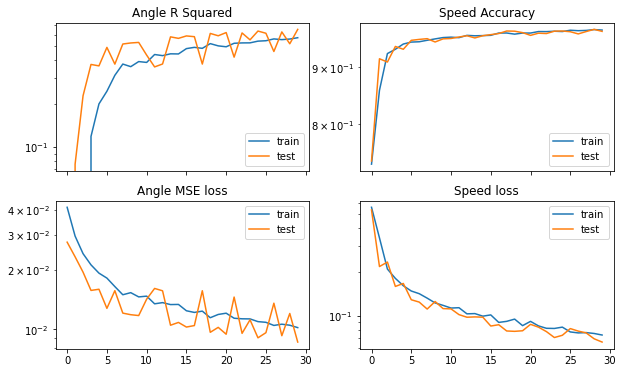

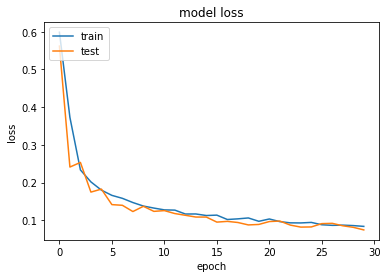

In [40]:
plots(history)


In [41]:
testgen = ImageDataGenerator()

predict = model.predict(val_gen.flow_from_directory('../datasets/PiCar/test',target_size=(240,180)))

Found 1020 images belonging to 1 classes.
32/32 [==============================] - 2s 72ms/step


In [42]:
angles = pd.DataFrame(predict[0], columns=['Angle'])
speed = pd.DataFrame(predict[1], columns=['speed'])
pred_df = pd.concat([angles, speed],axis=1)
pred_df.insert(0,"image_id", np.arange(1,len(pred_df)+1))

pred_df

,image_id,Angle,speed
0,1,0.430256,0.000645
1,2,0.575069,0.997984
2,3,0.333392,0.996077
3,4,0.438986,0.773544
4,5,0.398463,0.940280
...,...,...,...
1015,1016,0.346845,0.796944
1016,1017,0.556941,0.002548
1017,1018,0.445638,0.039080
1018,1019,0.521530,0.728034


In [43]:
pred_df = pred_df.round({'Angle': 4, 'speed': 0})
pred_df

,image_id,Angle,speed
0,1,0.4303,0.0
1,2,0.5751,1.0
2,3,0.3334,1.0
3,4,0.4390,1.0
4,5,0.3985,1.0
...,...,...,...
1015,1016,0.3468,1.0
1016,1017,0.5569,0.0
1017,1018,0.4456,0.0
1018,1019,0.5215,1.0


In [44]:
pred_df.to_csv('Tow_mat5.csv', index=False)

## Standalone models

In [13]:
class angle_CNN(tf.keras.Model):
  def __init__(self):
    super().__init__()
    
    self.conv1 = Conv2D(24, 5,strides=(2, 2), activation='relu')
    self.conv2 = Conv2D(36, 5, strides=(2, 2),activation='relu')
    self.conv3 = Conv2D(48, 5, strides=(2, 2),activation='relu')
    self.conv4 = Conv2D(64, 3, strides=(2, 2), activation='relu')
    self.drop1 = Dropout(0.25)
    self.conv5 = Conv2D(64, 3, strides=(2, 2),activation='relu')
    
    self.flatten = Flatten()
    self.drop2 = Dropout(0.25)
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(64, activation='relu')
    self.d3 = Dense(32, activation='relu')
    self.d4 = Dense(16, activation='relu')
    
    self.D4 = Dense(17, activation='softmax')
    #self.D5 = Dense(1, activation = 'sigmoid')

  def call(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.drop1(x)
    x = self.conv5(x)
    
    x = self.flatten(x)
    x = self.drop2(x)
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    x = self.d4(x)
    
    y1 = self.D4(x)
    #y2 = self.D5(x)
    
    
    
    return y1

In [14]:
train_gen = ImageDataGenerator(shear_range = 0.2, zoom_range =0.2, rotation_range=20,
                               width_shift_range=0.2, height_shift_range=0.2,brightness_range=[0.4,1.5])
val_gen = ImageDataGenerator()

model = angle_CNN()
#model = CNN().full_model()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(train_gen.flow_from_dataframe(X_train,x_col='images',y_col='angle',class_mode='raw',
                                        target_size=(240,180),batch_size=32),
    validation_data=val_gen.flow_from_dataframe(X_valid, x_col='images',y_col='angle',class_mode='raw',
    target_size=(240,180),batch_size=32), epochs=20)

model.save('model/angle_CNN',save_format='tf')

Found 11034 validated image filenames.
Found 2759 validated image filenames.
Epoch 1/20
345/345 [==============================] - 118s 338ms/step - loss: 2.2410 - accuracy: 0.1878 - val_loss: 1.8291 - val_accuracy: 0.3103
Epoch 2/20
345/345 [==============================] - 115s 332ms/step - loss: 1.9276 - accuracy: 0.2668 - val_loss: 1.7275 - val_accuracy: 0.3240
Epoch 3/20
345/345 [==============================] - 115s 334ms/step - loss: 1.8461 - accuracy: 0.2756 - val_loss: 1.6661 - val_accuracy: 0.3483
Epoch 4/20
345/345 [==============================] - 115s 332ms/step - loss: 1.7911 - accuracy: 0.2877 - val_loss: 1.6862 - val_accuracy: 0.2541
Epoch 5/20
345/345 [==============================] - 115s 333ms/step - loss: 1.7600 - accuracy: 0.2917 - val_loss: 1.6754 - val_accuracy: 0.3117
Epoch 6/20
345/345 [==============================] - 116s 336ms/step - loss: 1.7576 - accuracy: 0.2983 - val_loss: 1.6080 - val_accuracy: 0.3171
Epoch 7/20
345/345 [===========================

INFO:tensorflow:Assets written to: model/angle_CNN/assets


INFO:tensorflow:Assets written to: model/angle_CNN/assets


In [16]:
def singlePlots(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

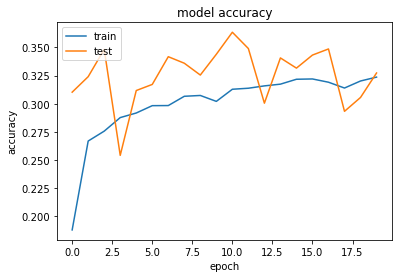

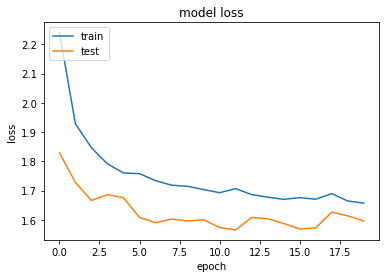

In [17]:
singlePlots(history)

In [25]:
class speed_CNN(tf.keras.Model):
  def __init__(self):
    super().__init__()
    
    self.conv1 = Conv2D(24, 5, activation='relu')
    self.conv2 = Conv2D(36, 5, activation='relu')
    self.conv3 = Conv2D(48, 5, activation='relu')
    self.conv4 = Conv2D(64, 3, activation='relu')
    self.conv5 = Conv2D(64, 3, activation='relu')
    
    self.flatten = Flatten()
    self.d1 = Dense(100, activation='relu')
    self.d2 = Dense(50, activation='relu')
    
    #self.D4 = Dense(17, activation='softmax')
    self.D5 = Dense(1, activation = 'sigmoid')

  def call(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    
    x = self.flatten(x)
    x = self.d1(x)
    x = self.d2(x)
    
    #y1 = self.D4(x)
    y2 = self.D5(x)
    
    
    
    return y2

In [26]:
train_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()

model = speed_CNN()
#model = CNN().full_model()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.fit(train_gen.flow_from_dataframe(X_train,x_col='images',y_col='speed',class_mode='raw',
                                        target_size=(200,66),batch_size=32),
    validation_data=val_gen.flow_from_dataframe(X_valid, x_col='images',y_col='speed',class_mode='raw',
    target_size=(200,66),batch_size=32), epochs=20)

model.save('model/speed_CNN',save_format='tf')

Found 11034 validated image filenames.
Found 2759 validated image filenames.
Epoch 1/20
345/345 [==============================] - 42s 115ms/step - loss: 17.6693 - accuracy: 0.8088 - val_loss: 0.2366 - val_accuracy: 0.9094
Epoch 2/20
345/345 [==============================] - 38s 109ms/step - loss: 0.1520 - accuracy: 0.9446 - val_loss: 0.1328 - val_accuracy: 0.9496
Epoch 3/20
345/345 [==============================] - 37s 106ms/step - loss: 0.0800 - accuracy: 0.9711 - val_loss: 0.1405 - val_accuracy: 0.9496
Epoch 4/20
345/345 [==============================] - 33s 95ms/step - loss: 0.0474 - accuracy: 0.9838 - val_loss: 0.1538 - val_accuracy: 0.9507
Epoch 5/20
345/345 [==============================] - 32s 94ms/step - loss: 0.0343 - accuracy: 0.9876 - val_loss: 0.2297 - val_accuracy: 0.9387
Epoch 6/20
345/345 [==============================] - 42s 123ms/step - loss: 0.0410 - accuracy: 0.9863 - val_loss: 0.2041 - val_accuracy: 0.9456
Epoch 7/20
345/345 [==============================] - 

INFO:tensorflow:Assets written to: model/speed_CNN\assets


INFO:tensorflow:Assets written to: model/speed_CNN\assets
